In [1]:
import matplotlib.pyplot as plt
import tensorflow as tf
import numpy as np
import pandas as pd
import cv2
import pickle
import os
import random
from tqdm import tqdm

In [2]:
plt.rcParams['figure.figsize'] = (20,10)
plt.rcParams.update({'font.size': 12})
pd.set_option('display.max_columns', 2000)

In [3]:
train_path = "notMNIST_large"
test_path = "notMNIST_small"

In [6]:
def get_labeling_data(path_folder):
    root_folders = []
    lens_folders = []
    sort_path = os.listdir(path_folder)
    sort_path.sort()
    for num, i in enumerate(sort_path):
        path = os.path.join(path_folder,i)
        root_folders.append(path)
        lens_folders.append([path, len(os.listdir(path))])
    print('Folder', 13*' ', 'Size' )
    for x in lens_folders: print(x)    
    
    _img_Labels_file = []
    for i,v in enumerate(root_folders):
        if v :
            for file in os.listdir(v):
                try:
                    file_path = os.path.join(v,file)
                    img = cv2.imread(file_path,cv2.IMREAD_GRAYSCALE)
                    resize_img = cv2.resize(img,(28,28))
                    _img_Labels_file.append([i,resize_img])
                except Exception as e:
                    pass
    return _img_Labels_file, lens_folders

In [7]:
img_lbls_train, len_train = get_labeling_data(train_path)
img_lbls_test, len_test = get_labeling_data(test_path)

Folder               Size
['notMNIST_large/A', 52912]
['notMNIST_large/B', 52912]
['notMNIST_large/C', 52912]
['notMNIST_large/D', 52912]
['notMNIST_large/E', 52912]
['notMNIST_large/F', 52912]
['notMNIST_large/G', 52912]
['notMNIST_large/H', 52912]
['notMNIST_large/I', 52912]
['notMNIST_large/J', 52911]
Folder               Size
['notMNIST_small/A', 1873]
['notMNIST_small/B', 1873]
['notMNIST_small/C', 1873]
['notMNIST_small/D', 1873]
['notMNIST_small/E', 1873]
['notMNIST_small/F', 1873]
['notMNIST_small/G', 1872]
['notMNIST_small/H', 1872]
['notMNIST_small/I', 1872]
['notMNIST_small/J', 1872]


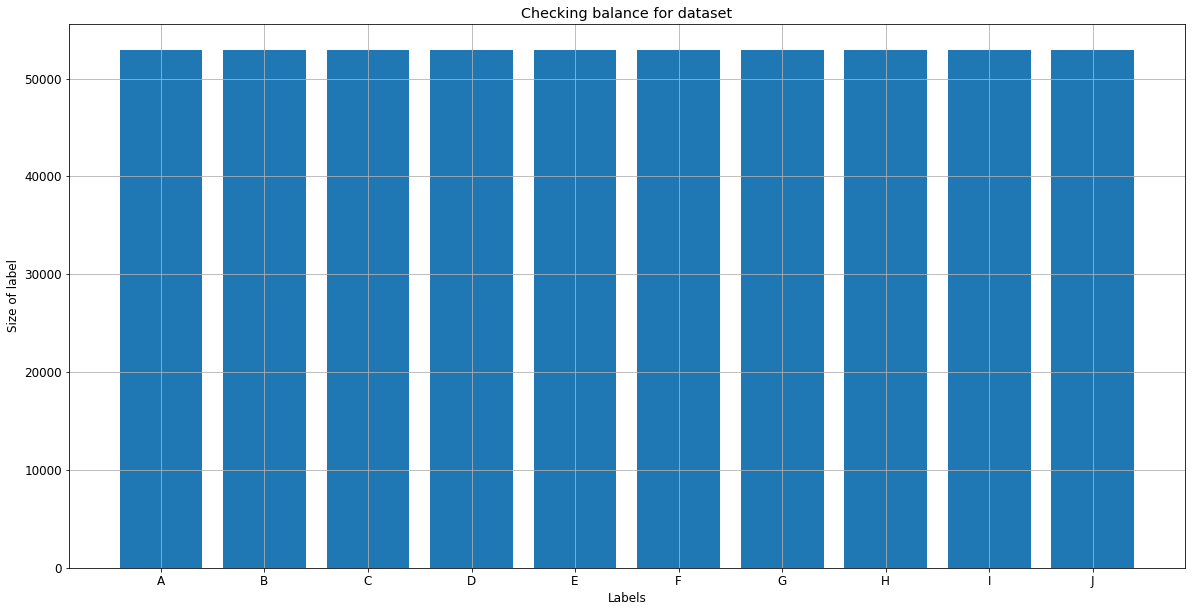

In [26]:
plt.bar(np.arange(10), pd.DataFrame(len_train)[1])
plt.ylabel('Size of label')
plt.xlabel('Labels')
plt.xticks(np.arange(10), np.sort(labels))
plt.title('Checking balance for dataset')
plt.grid()
plt.show()

In [47]:
img_common_data = img_lbls_train + img_lbls_test

In [48]:
random.shuffle(img_common_data)

In [49]:
X, Y = [], []
for labels, features  in enumerate(img_common_data):
    X.append(features[1])
    Y.append(features[0])

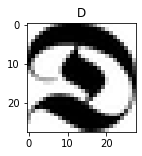

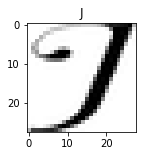

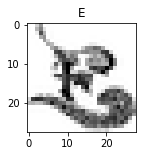

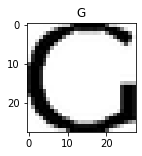

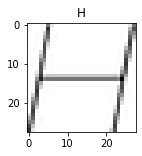

In [53]:
plt.rcParams['figure.figsize'] = (2,2)
for i in np.random.randint(0, len(X), 5):
    plt.imshow(X[i], 'binary')
    plt.title(labels[Y[i]])
    plt.show()

In [54]:
pickle_out = open("NotMnist_filterd_data/X_features.pickle","wb")
pickle.dump(X, pickle_out)
pickle_out.close()

pickle_out = open("NotMnist_filterd_data/Y_labels.pickle","wb")
pickle.dump(Y, pickle_out)
pickle_out.close()

In [4]:
X_features = pickle.load(open("NotMnist_filterd_data/X_features.pickle","rb"))
Y_labels = pickle.load(open("NotMnist_filterd_data/Y_labels.pickle","rb"))

In [5]:
X_features = np.array(X_features) / 255 # normalization of data for easy to calculations.
Y_labels = np.array(Y_labels)

In [6]:
X_features = X_features.reshape(-1, 28*28)

In [7]:
TRAIN = 200000
VAL = 10000
TEST = 19000

In [8]:
x_train, y_train = X_features[:TRAIN], Y_labels[:TRAIN]
x_val, y_val = X_features[TRAIN:TRAIN+VAL], Y_labels[TRAIN:TRAIN+VAL]
x_test, y_test = X_features[TRAIN+VAL:TRAIN+VAL+TEST], Y_labels[TRAIN+VAL:TRAIN+VAL+TEST]

In [9]:
print('Train: ',x_train.shape, y_train.shape)
print('Validation: ', x_val.shape, y_val.shape)
print('Test: ', x_test.shape, y_test.shape)

Train:  (200000, 784) (200000,)
Validation:  (10000, 784) (10000,)
Test:  (19000, 784) (19000,)


In [ ]:
dirs = os.listdir(train_path)
fig, ax = plt.subplots(2, 5, figsize=(16, 6))

for i in range(2):
    for j in range(5):
        dr = random.choice(dirs)
        im = random.choice(os.listdir(os.path.join(im_root, dr)))
        ax[i, j].imshow(plt.imread(os.path.join(im_root, dr, im)), cmap='gray')
        ax[i, j].set_title(dr)
        ax[i, j].axis('off')

In [11]:
from hashlib import sha1

In [14]:
def get_dataset_hash(dataset):
    return [sha1(dataset_instance).digest() for dataset_instance in dataset]

train_dataset_hash = get_dataset_hash(x_train)
valid_dataset_hash = get_dataset_hash(x_val)
test_dataset_hash = get_dataset_hash(x_test)

duplicates_in_train_and_valid_dataset = np.intersect1d(train_dataset_hash, valid_dataset_hash)
duplicates_in_train_and_test_dataset = np.intersect1d(train_dataset_hash, test_dataset_hash)
duplicates_in_valid_and_test_dataset = np.intersect1d(test_dataset_hash, valid_dataset_hash)

duplicates = np.hstack(
                       (duplicates_in_train_and_valid_dataset,
                        duplicates_in_train_and_test_dataset,
                        duplicates_in_valid_and_test_dataset)
                      )

def clean_dataset(dataset, dataset_hash, exclude_hash):
    return np.array([
                   dataset[index] for index in 
                   np.arange(dataset.shape[0]) if
                   dataset_hash[index] not in 
                   exclude_hash
                 ])

cleaned_valid_dataset = clean_dataset(x_val, valid_dataset_hash, duplicates)
cleaned_test_dataset = clean_dataset(x_test, test_dataset_hash, duplicates)

print ('Original valid dataset shape',  x_val.shape)
print ('Cleaned valid dataset shape', cleaned_valid_dataset.shape)
print ('Original test dataset shape',  x_test.shape)
print ('Cleaned test dataset shape', cleaned_test_dataset.shape)

Original valid dataset shape (10000, 784)
Cleaned valid dataset shape (8807, 784)
Original test dataset shape (19000, 784)
Cleaned test dataset shape (16880, 784)


In [16]:
from sklearn.linear_model import LogisticRegression
from sklearn.metrics import f1_score, confusion_matrix, multilabel_confusion_matrix

In [17]:
logit = LogisticRegression(multi_class='multinomial', solver='lbfgs', random_state=42,
                          verbose=1, max_iter=1000, n_jobs=-1)
logit.fit(x_train, y_train)
y_pred_val = logit.predict(x_val)
y_pred_test = logit.predict(x_test)
print("Score on train: ", logit.score(x_train, y_train))
print("Score on val: ", logit.score(x_val, y_val))
print("Score on test: ", logit.score(x_test, y_test))
print("F1 score on val: ", f1_score(y_val, y_pred_val, average='weighted'))
print("F1 score on test: ", f1_score(y_test, y_pred_test, average='weighted'))

[Parallel(n_jobs=-1)]: Using backend SequentialBackend with 1 concurrent workers.
/home/aksel/anaconda3/lib/python3.7/site-packages/sklearn/linear_model/logistic.py:947: ConvergenceWarning: lbfgs failed to converge. Increase the number of iterations.
  "of iterations.", ConvergenceWarning)
[Parallel(n_jobs=-1)]: Done   1 out of   1 | elapsed: 13.1min finished


Score on train:  0.842815
Score on val:  0.8337
Score on test:  0.8336842105263158
F1 score on val:  0.8337709491902638
F1 score on test:  0.8335700164828316


In [18]:
print('Confusion matrix on val')
confusion_matrix(y_val, y_pred_val)

Confusion matrix on val


array([[780,  19,   6,   9,   8,  16,  24,  44,  27,  15],
       [ 13, 818,  12,  44,  19,  13,  21,  20,  34,  17],
       [  6,   6, 912,   7,  24,   9,  22,  10,  22,   4],
       [ 19,  42,  10, 895,  11,  21,  10,  17,  23,  14],
       [  8,  19,  58,  16, 837,  26,  20,  15,  35,   7],
       [ 12,   7,  11,   8,  16, 847,  20,  14,  19,  21],
       [ 15,  19,  38,  22,   8,  26, 819,  13,  22,  21],
       [ 41,  20,   7,  14,   9,  19,  12, 805,  34,  11],
       [ 19,  11,   8,  15,  21,  17,  21,  32, 807,  44],
       [ 16,   9,   8,  15,   8,  21,  16,  14,  47, 817]])

In [19]:
print('Confusion matrix on test')
confusion_matrix(y_test, y_pred_test)

Confusion matrix on test


array([[1501,   36,   16,   21,   18,   25,   29,   66,   39,   42],
       [  21, 1544,   14,   90,   40,   24,   48,   46,   59,   31],
       [   9,   19, 1736,   18,   43,   22,   49,   20,   32,   14],
       [  28,   56,   19, 1603,   14,   27,   22,   27,   34,   23],
       [  24,   54,   98,   18, 1528,   54,   46,   26,   68,   19],
       [  24,   17,   29,   17,   28, 1657,   36,   23,   58,   41],
       [  29,   37,   71,   27,   22,   36, 1567,   30,   40,   30],
       [  49,   33,    5,   21,   25,   30,   27, 1545,   57,   34],
       [  48,   36,   27,   32,   51,   40,   47,   57, 1507,  109],
       [  42,    9,   17,   28,   12,   34,   32,   26,   89, 1652]])

In [74]:
logit_test = []
training_samples = [50, 100, 1000, 10000, 50000]
for train_examples_count in training_samples:
    logit =LogisticRegression(multi_class='multinomial', solver='lbfgs', random_state=42,
                              verbose=1, max_iter=1000, n_jobs=-1)
    train_data = x_train[:train_examples_count]
    train_lbl = y_train[:train_examples_count]
    logit.fit(train_data, train_lbl)
    y_pred = logit.predict(x_test)
    print("Score on test: ", logit.score(x_test, y_test))
    print("F1 score on test: ", f1_score(y_test, y_pred, average='weighted'))
    logit_test.append([logit.score(x_test, y_test), f1_score(y_test, y_pred, average='weighted')])

  0%|          | 0/5 [00:00<?, ?it/s][Parallel(n_jobs=-1)]: Using backend SequentialBackend with 1 concurrent workers.
[Parallel(n_jobs=-1)]: Done   1 out of   1 | elapsed:    0.3s finished
 20%|██        | 1/5 [00:00<00:01,  2.54it/s][Parallel(n_jobs=-1)]: Using backend SequentialBackend with 1 concurrent workers.


Score on test:  0.5605263157894737
F1 score on test:  0.5646795840245695


[Parallel(n_jobs=-1)]: Done   1 out of   1 | elapsed:    0.4s finished
 40%|████      | 2/5 [00:00<00:01,  2.39it/s][Parallel(n_jobs=-1)]: Using backend SequentialBackend with 1 concurrent workers.


Score on test:  0.6546315789473685
F1 score on test:  0.6562622260013384


[Parallel(n_jobs=-1)]: Done   1 out of   1 | elapsed:    0.8s finished
 60%|██████    | 3/5 [00:01<00:01,  1.77it/s][Parallel(n_jobs=-1)]: Using backend SequentialBackend with 1 concurrent workers.


Score on test:  0.7757894736842105
F1 score on test:  0.7760117293469354


[Parallel(n_jobs=-1)]: Done   1 out of   1 | elapsed:   12.4s finished
 80%|████████  | 4/5 [00:14<00:04,  4.13s/it][Parallel(n_jobs=-1)]: Using backend SequentialBackend with 1 concurrent workers.


Score on test:  0.7861052631578948
F1 score on test:  0.7860514572725307


/home/aksel/anaconda3/lib/python3.7/site-packages/sklearn/linear_model/logistic.py:947: ConvergenceWarning: lbfgs failed to converge. Increase the number of iterations.
  "of iterations.", ConvergenceWarning)
[Parallel(n_jobs=-1)]: Done   1 out of   1 | elapsed:  1.3min finished
100%|██████████| 5/5 [01:29<00:00, 17.90s/it]

Score on test:  0.8202631578947368
F1 score on test:  0.8200954930582516


In [88]:
logit_test = pd.DataFrame(logit_test)

In [89]:
import seaborn as sn
sn.set_style('whitegrid')
plt.rcParams['figure.figsize'] = (20,10)
pd.set_option('display.max_columns', 2000)
plt.rcParams.update({'font.size': 12})

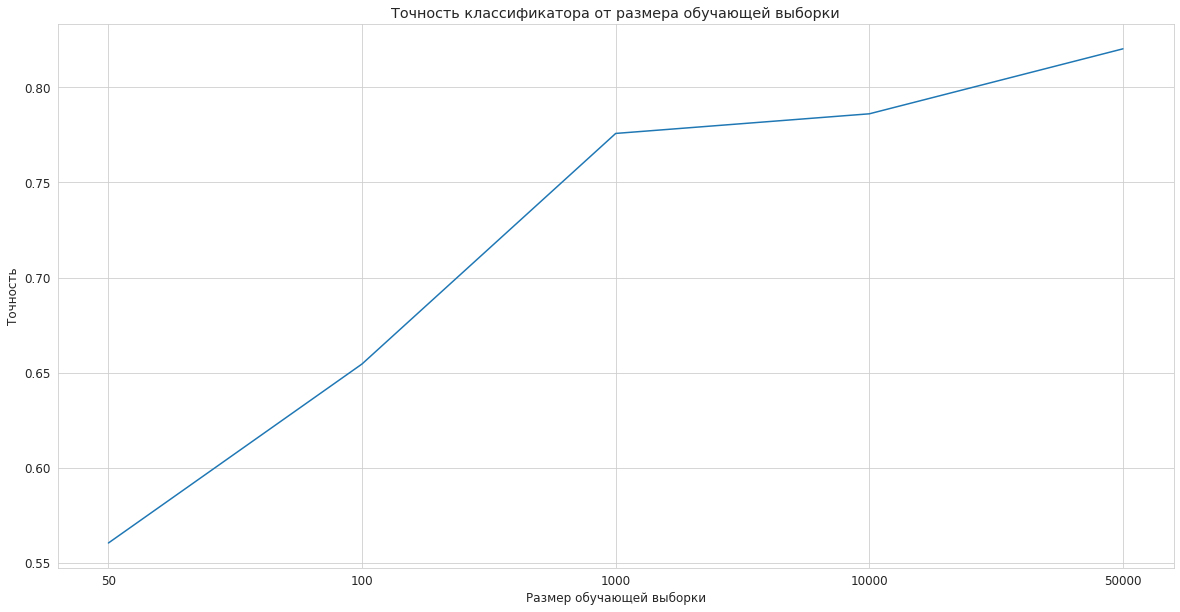

In [90]:
plt.plot(logit_test[0])
plt.xticks(range(len(training_samples)),training_samples)
plt.title('Точность классификатора от размера обучающей выборки')
plt.xlabel('Размер обучающей выборки')
plt.ylabel('Точность')
plt.show()

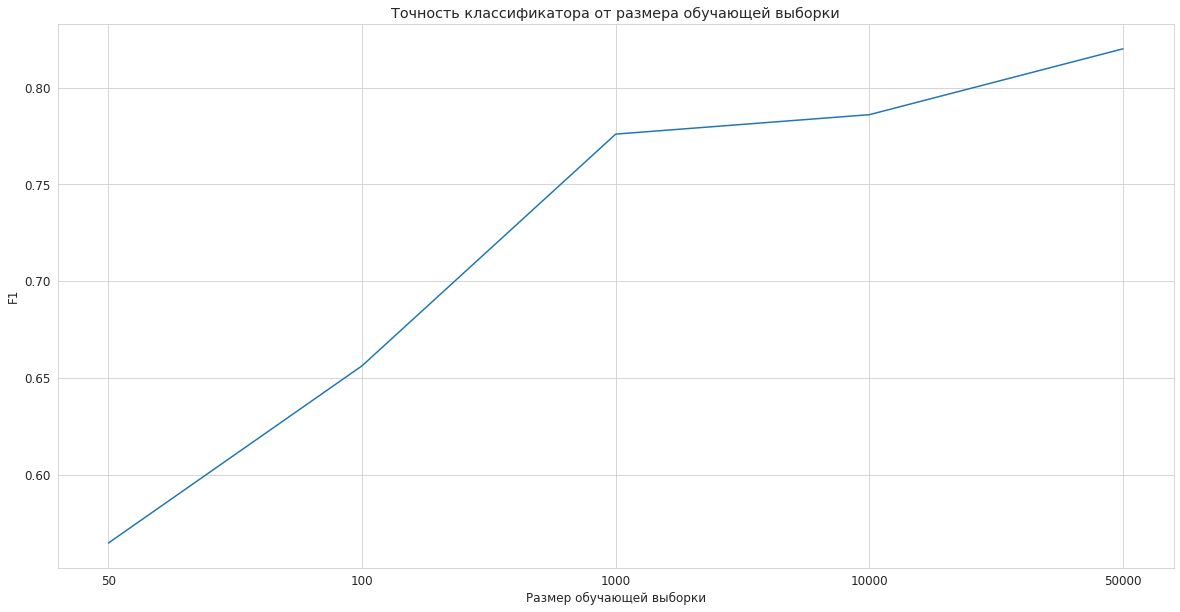

In [91]:
plt.plot(logit_test[1])
plt.xticks(range(len(training_samples)),training_samples)
plt.title('Точность классификатора от размера обучающей выборки')
plt.xlabel('Размер обучающей выборки')
plt.ylabel('F1')
plt.show()